# Understand Citoid coverage for Web2Cit

This notebook describes how to retrieve the source code and the [Citation templates](https://en.wikipedia.org/wiki/Wikipedia:Citation_templates) of the citations of a sample of Wikipedia articles to compare them with the results of the [Citoid](https://www.mediawiki.org/wiki/Citoid) API for the same citations.

To follow along, we recommend running the script portions piecemeal, in order.

__Author:__

* Nidia Hernández, [nidiahernandez@conicet.gov.ar](mailto:nidiahy@gmail.com), [CAICYT-CONICET](http://www.caicyt-conicet.gov.ar/sitio/) (Argentina)


## Table of Contents

0. Setting Up 
1. Retrieving data from Wikipedia articles
    - 1.1. Fetching featured articles using Mediawiki's action API
    - 1.2. Retrieving featured articles data
2. Citation template metadata extraction
    - 2.1 Parameter name mapping
    - 2.2 Inspecting all featured articles
    - 2.3 Citation template extraction summary
3. Querying Citoid API
    - 3.1 Validating URLs
    - 3.2 Query function and parallel requests
    - 3.3 Tidying up Citoid's response
4. Data normalization
    - 4.1 Manual data
    - 4.2 Citoid data
5. Evaluation
    - 5.1 Source type
    - 5.2 Publishing date
    - 5.3 Title and publishing source
    - 5.4 Author
    - 5.5 Applying comparison methods
6. Results
    - 6.1. By URL
    - 6.2. By domain
    - 6.3 By fieldname

## 0. Setting Up

Before we get started, let's install and import the libraries that we will need.

In [2]:
import re
import os
import requests
import urllib
import pandas as pd
from operator import itemgetter
import json
import gzip
from glob import glob
from pprint import pprint
from tqdm import tqdm
tqdm.pandas()
import mwparserfromhell
import validators
from datetime import datetime
import concurrent.futures
from time import sleep
from more_itertools import chunked
from unidecode import unidecode
from ast import literal_eval
import dateparser
from nltk.metrics import edit_distance
from itertools import permutations
import numpy as np

/home/yoki/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Here we set the global parameters:

In [ ]:
HEADER={'User-Agent': 'https://phabricator.wikimedia.org/tag/web2cit-research/; mailto:nidiahernandez@conicet.gov.ar'}

## 1. Retrieving data from Wikipedia articles

In this section, we will fetch all the featured articles from a selection of Wikipedias ir order to find:

- the citation templates used on each article
- the URLs of the citations

The selected Wikipedias are the following:

- [English Wikipedia](https://en.wikipedia.org/wiki/Category:Featured_articles): ~6k featured articles
- [Spanish Wikipedia](https://es.wikipedia.org/wiki/Categor%C3%ADa:Wikipedia:Art%C3%ADculos_destacados): ~1.2k artículos destacados
- [French Wikipedia](https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Article_de_qualit%C3%A9): ~2k articles de qualité
- [Portuguese Wikipedia](https://pt.wikipedia.org/wiki/Categoria:!Artigos_destacados): ~1.3k artigos destacados

Some general information about featured articles in all Wikipedias: https://meta.wikimedia.org/wiki/Wikipedia_featured_articles (out of date).

#### Featured content endpoint in Mediawiki's API

There is a specific endpoint for featured content in Mediawiki's API:

https://api.wikimedia.org/feed/v1/wikipedia/{lang}/featured/

For example, the request https://api.wikimedia.org/feed/v1/wikipedia/en/featured/2021/12/06 returns today's featured article (tfa) for December 6th 2021 in English Wikipedia.

Unfortunatatly, this is not avalilable for all the Wikipedias of our interest because "not all Wikipedias are integrated into the Feed endpoint" ([Feed endpoint doc](https://api.wikimedia.org/wiki/API_reference/Feed/Featured_content)). This way, the request https://api.wikimedia.org/feed/v1/wikipedia/fr/featured/2021/12/06 does not return tfa info. Same for Spanish and Portuguese. For this reason, we do not use this specific endpoint.

### 1.1 Fetching featured articles using Mediawiki's action API

We will use each [Wikipedias' action API](https://www.mediawiki.org/wiki/API:Main_page) to retrive:

1. the list of all featured articles for each language
2. the wikicode and some metadata of each featured article

The action API has the following URL:

`https://{lang}.wikipedia.org/w/api.php?`

The following request, for example, retrieves the first 15 featured articles for the category "Articles de qualité" in French Wikipedia:

In [ ]:
title = urllib.parse.unquote("Cat%C3%A9gorie:Article_de_qualit%C3%A9") # category name for featured articles in French Wikipedia

PARAMS = {
    "action": "query",
    "list": "categorymembers",
    "cmtitle": title,
    "cmlimit": 15,
    "format": "json"
}

response = requests.get(
    url='https://fr.wikipedia.org/w/api.php?', 
    params=PARAMS
)

response_data = response.json()

There is a max of 500 per request. In order to retrieve all the members of the category, we should add the parameter `cmcontinue` to our request as follows: we get the value of `cmcontinue` from the response of the first request and pass it to the following request. This repeats until the end of the list. See API doc for more details on listing category members: https://www.mediawiki.org/wiki/API:Categorymembers.

In [ ]:
response_data['continue']['cmcontinue'] # here is the reference of the starting point for the next request

'page|2a2e38324232443a30324e01428844880901dc10|52519'

In the response, we obtain a list showing the pageid and the title of each article:

In [ ]:
response_data['query']['categorymembers']

[{'pageid': 507899, 'ns': 4, 'title': 'Wikipédia:Articles de qualité'},
 {'pageid': 9253139, 'ns': 0, 'title': '1 000 kilomètres de Spa 2009'},
 {'pageid': 10267261, 'ns': 0, 'title': '6 Heures du Castellet 2011'},
 {'pageid': 91996, 'ns': 0, 'title': '32X'},
 {'pageid': 605584, 'ns': 0, 'title': 'Les 101 Dalmatiens (film, 1961)'},
 {'pageid': 5008651, 'ns': 0, 'title': 'A Different Corner'},
 {'pageid': 639219, 'ns': 0, 'title': "A Hard Day's Night (album)"},
 {'pageid': 6672844, 'ns': 0, 'title': "À l'Olympia (album d'Alan Stivell)"},
 {'pageid': 124634, 'ns': 0, 'title': 'À la croisée des mondes'},
 {'pageid': 1486250, 'ns': 0, 'title': "L'Abbaye de Northanger"},
 {'pageid': 11085052, 'ns': 0, 'title': 'Abbaye Saint-Paul de Cormery'},
 {'pageid': 1210952, 'ns': 0, 'title': 'Abbaye Saint-Victor de Marseille'},
 {'pageid': 4293975, 'ns': 0, 'title': "Parc national d'Abisko"},
 {'pageid': 1415801, 'ns': 0, 'title': 'Acanthaster planci'},
 {'pageid': 3906668,
  'ns': 0,
  'title': 'Acci

If the item is a featured article, `ns` (namespace) is `0`. So, to avoid retriving other items (meta-pages about other categories, for example) elements having other values for this key must be discarded (cf. Retrieve article data below).

Let's request all the featured articles for each language and dump the response to a json:

In [ ]:
# the name of the category in each language
catname_bylang = {
    'en': 'Category:Featured_articles',
    'es': 'Categor%C3%ADa:Wikipedia:Art%C3%ADculos_destacados',
    'fr': 'Cat%C3%A9gorie:Article_de_qualit%C3%A9',
    'pt': 'Categoria:!Artigos_destacados',
}

In [ ]:
for lang in tqdm(catname_bylang, desc='Retrieving featured articles'):
    
    MEDIAWIKI_API_URL = f'https://{lang}.wikipedia.org/w/api.php?'
    
    category_title = urllib.parse.unquote(catname_bylang[lang])
    cmcont = "start"
    i = 0
    
    while (cmcont == "start") or cmcont.startswith('page'):
        i += 1
        filename = f'data/featured-articles/{lang}-{i:02}.json'
        
        if os.path.isfile(filename):
            with open(filename) as fi:
                featured_art_json = json.load(fi)
                if 'continue' in featured_art_json:
                    cmcont = featured_art_json['continue']['cmcontinue']
                else:
                    cmcont = "end"

            continue
        
        PARAMS = {
            "action": "query",
            "list": "categorymembers",
            "cmtitle": category_title,
            "cmlimit": "max", 
            "format": "json",
            "curtimestamp": True
        }
            
        if cmcont.startswith('page'):
            PARAMS["cmcontinue"]=cmcont

        response = requests.get(
            url=MEDIAWIKI_API_URL, 
            params=PARAMS,
            headers=HEADER
        )

        data = response.json()

        if response.status_code == 200:

            if 'continue' in data:
                cmcont = data['continue']['cmcontinue']
            
            else:
                cmcont='categoryend'

            with open(filename, 'w') as fo:
                fo.write(json.dumps(data))

Retrieving featured articles: 100%|██████████| 4/4 [00:00<00:00, 176.40it/s]


### 1.2 Retrieve featured articles data

Now that we have the pageids of all the featured articles, we can use them to retrieve the URL, the content and the id of the last edition (`revid`). First, we load the information from the json and we build a dataframe where we will store the data for each featured article:

In [ ]:
dfs = []

for fname in sorted(os.listdir('featured-articles')):
    if fname.endswith('.json'):
        
        wikilang = fname.split('-')[0]
        
        with open(f'featured-articles/{fname}') as fi:
            featured_arts = json.load(fi)
            
        df = pd.DataFrame(featured_arts['query']['categorymembers'])
        df['wiki_lang'] = wikilang
        df = df[df['ns'] == 0] # discard items that are not featured articles
        df.drop('ns', axis='columns', inplace = True)

        dfs.append(df)
    
articles_data = pd.concat(dfs, ignore_index= True)
articles_data.rename(columns={'title':'article_title'}, inplace = True)
articles_data.drop_duplicates(inplace = True)

In [ ]:
articles_data

,pageid,article_title,wiki_lang
0,33653136,? (film),en
1,1849799,0.999...,en
2,9702578,1 − 2 + 3 − 4 + ⋯,en
3,48723612,1st Cavalry Division (Kingdom of Yugoslavia),en
4,64662351,1st Missouri Field Battery,en
...,...,...,...
15065,132185,Yorkshire terrier,pt
15066,2269483,You Belong with Me,pt
15067,4779921,You Don't Know What to Do,pt
15068,1585284,You Know I'm No Good,pt


We add a new column containing the URL of each article using the information from the article title and the language of the wikipedia:

In [ ]:
articles_data['article_url'] = "https://"+articles_data['wiki_lang']+".wikipedia.org/wiki/"+articles_data['article_title'].map(urllib.parse.quote)

In [ ]:
articles_data

,pageid,article_title,wiki_lang,article_url
0,33653136,? (film),en,https://en.wikipedia.org/wiki/%3F%20%28film%29
1,1849799,0.999...,en,https://en.wikipedia.org/wiki/0.999...
2,9702578,1 − 2 + 3 − 4 + ⋯,en,https://en.wikipedia.org/wiki/1%20%E2%88%92%202%20%2B%203%20%E2%88%92%204%20%2B%20%E2%8B%AF
3,48723612,1st Cavalry Division (Kingdom of Yugoslavia),en,https://en.wikipedia.org/wiki/1st%20Cavalry%20Division%20%28Kingdom%20of%20Yugoslavia%29
4,64662351,1st Missouri Field Battery,en,https://en.wikipedia.org/wiki/1st%20Missouri%20Field%20Battery
...,...,...,...,...
15065,132185,Yorkshire terrier,pt,https://pt.wikipedia.org/wiki/Yorkshire%20terrier
15066,2269483,You Belong with Me,pt,https://pt.wikipedia.org/wiki/You%20Belong%20with%20Me
15067,4779921,You Don't Know What to Do,pt,https://pt.wikipedia.org/wiki/You%20Don%27t%20Know%20What%20to%20Do
15068,1585284,You Know I'm No Good,pt,https://pt.wikipedia.org/wiki/You%20Know%20I%27m%20No%20Good


We save this information to a csv file:

In [ ]:
articles_data.to_csv('data/featured_articles.csv', index=False)

Now we are ready to query Mediawiki's action API again to get the content of each featured article. 

For example, to retrieve the wikitext and the id of the last edition for the article #3906668 'Accident sur la base de Fairchild en 1994' from French Wikipedia, we can do the following request:

In [ ]:
pageid = 3906668

PARAMS = {
    "action": "parse",
    "pageid": pageid,
    "prop": "wikitext|revid",
    "format": "json"
}

response = requests.get(
    url='https://fr.wikipedia.org/w/api.php?', 
    params=PARAMS,
)

page_data = response.json()

In [ ]:
page_data

{'parse': {'title': 'Accident sur la base de Fairchild en 1994',
  'pageid': 3906668,
  'revid': 186075124,
  'wikitext': {'*': '{{En-tête label|AdQ}}\n{{Infobox Accident de transport\n  | nom                  = Accident du B-52 sur la base de Fairchild en 1994\n  | image                = FairchildB52Crash.jpg\n  | légende              = Le B-52 sur la tranche une seconde avant de toucher le sol.\n  | date                 = {{date|24|juin|1994|en aéronautique}}\n  | phase                = Vol d\'entraînement\n  | type                 = Erreur de pilotage\n  | site                 = [[Fairchild Air Force Base]], [[Washington (État)|Washington]], [[États-Unis]]\n  | passagers            = \n  | équipage             = 4 militaires\n  | morts                = 4 militaires\n  | blessés              = \n  | survivants           = \n  | appareil             = [[Boeing B-52 Stratofortress|Boeing B-52H \'\'Stratofortress\'\']]\n  | compagnie            = [[United States Air Force]]\n  | numéro_

Let's fetch the wikitext and the id of the last edition for each featured article and save the response to a compressed file:

In [ ]:
for index, row in tqdm(articles_data.iterrows(), desc='Retrieving data from articles'):

    pageid = articles_data.loc[index]['pageid']
    lang = articles_data.loc[index]['wiki_lang']
    filename = f'articles-content/{pageid}-{lang}.json.gz'
    
    MEDIAWIKI_API_URL = f'https://{lang}.wikipedia.org/w/api.php?'

    if not os.path.isfile(filename):

        PARAMS = {
            "action": "parse",
            "pageid": pageid,
            "prop": "wikitext|revid",
            "format": "json"
        }

        response = requests.get(
            url=MEDIAWIKI_API_URL, 
            params=PARAMS,
            headers=HEADER
        )

        page_data = response.json()

        if response.status_code == 200:
            with gzip.open(filename, 'w') as fo:
                fo.write(json.dumps(page_data).encode('utf-8'))
    
    else:
        continue


Retrieving data from articles: 10570it [00:06, 1640.30it/s]


## 2. Citation template metadata extraction

Now that we already have the wikitext of the articles, we will parse it in order to retrieve the references that were introduced using a citation template. In other words, we are not interested in:

1. Manually entered references (ie, which do not use citation templates)

`<ref name=Briggs>Briggs, Asa & Burke, Peter (2002) ''A Social History of the Media: from Gutenberg to the Internet'', Cambridge: Polity, pp. 15–23, 61–73.</ref>`

2. Unlinked references

```<ref name=Neeham>{{cite book |title=Paper and Printing |author=[[Tsien Tsuen-Hsuin]] |author2=[[Joseph Needham]] |series=Science and Civilisation in China|volume=5 part 1|publisher=Cambridge University Press|pages=158, 201|year=1985}}</ref> ```

An example of the type of references that we want to keep:

```<ref name="VB1992">{{cite journal|last1=Osmond|first1=Patricia J.|last2=Ulery|first2=Robert W.|date=2003|title=Sallustius|url=http://catalogustranslationum.org/PDFs/volume08/v08_sallustius.pdf#page=17|journal=[[Catalogus Translationum et Commentariorum]]|volume=8|page=199|access-date=27 August 2015}}</ref>```

Therefore, we parse the page content looking only for the citation templates including a URL.

### 2.1 Parameter name mapping

From each reference, we are interested in extracting the following metadata: 
1. The source type (journal, book, website, etc.)
1. The URL of the source
2. The author(s)
3. The title
4. The publishing date
5. The publishing source (publisher, location, etc.)

The names of each data may vary between templates. For instance, the publishing source is under "periodical" for the news template and under "publisher" for the books template. Or the publishing date might be called "date" or "year" in the maps template. The [following spreadsheet](https://docs.google.com/spreadsheets/d/1xbc3FKE0m4JQHa6WCXtBbzeJ9in8P0EQ2NF_VNsaBaM/edit#gid=0) maps the name of each parameter in the citations templates to our fieldnames:

In [ ]:
mapping_sheet = f'https://docs.google.com/spreadsheets/d/1xbc3FKE0m4JQHa6WCXtBbzeJ9in8P0EQ2NF_VNsaBaM/export?gid=0&format=csv'

fieldnames_df = pd.read_csv(mapping_sheet)
## rename columns
fieldnames_df.rename(columns={
    "Template": "template",
    "authorLast": "author_last",
    "authorFirst": "author_first",
    "pubDate": "pub_date",
    "source (published In + published By)": "pub_source"
}, inplace=True)

fieldnames_df

,wiki_lang,template,title,author_last,author_first,pub_date,pub_source
0,en,Cite web,title,"last\d*, author\d*",first\d*,date,"website, publisher"
1,es,Cita web,título,"apellidos?\d*, autor\d*",nombre\d*,fecha,"sitioweb, obra, publicación, editorial"
2,pt,Citar web,titulo,"ultimo\d*, autor\d*",primeiro\d*,data,"obra, publicado"
3,fr,Lien web,titre,"nom\d*, auteur\d*",prénom\d*,date,site
4,en,Cite book,title,"last\d*, author\d*",first\d*,date,"publication-place, location, publisher"
...,...,...,...,...,...,...,...
78,fr,Lien arXiv,titre,nom\d*,prénom\d*,date,eprint
79,pt,Citar arXiv,titulo,"ultimo\d*, autor\d*",primeiro\d*,data,eprint
80,en,Citation,title,last\d*,first\d*,date,"place, publisher"
81,es,Obra citada,título,apellidos?\d*,nombre\d*,fecha,editorial


The spreadsheet accepts several parameter names for the same field (`sitioweb, obra, publicación, editorial`) and it also accepts regular expressions (`apellidos?\d*`).

In [ ]:
for lang in fieldnames_df['wiki_lang'].unique():
    print(f"We have {len(fieldnames_df[fieldnames_df['wiki_lang'] == lang])} templates in {lang}")

We have 26 templates in en
We have 18 templates in es
We have 24 templates in pt
We have 12 templates in fr


### 2.2 Inspecting all featured articles

Taking this spreadsheet into account, we define some methods to extract the citation metadata from the articles:

In [ ]:
def read_article(filename):
    with gzip.open(filename) as fi:
        cont = json.loads(fi.read())
    return cont
    
def get_article_data(filename, cont):
    lang = os.path.basename(filename).split('-')[1].replace('.json.gz', '')
    pageid = cont['parse']['pageid'] 
    revid = cont['parse']['revid']
    article_title = cont['parse']['title']
    article_url = f'https://{lang}.wikipedia.org/wiki/{urllib.parse.quote(article_title)}'
    
    article_data = {
        "article_title": article_title,
        "article_url": article_url,
        "page_id": pageid,
        "revid": revid,
        "wiki_lang": lang,
    }
    return article_data

def normalize(s):
    return unidecode(s.lower())

def get_citation_data(fieldname, template, article_data):
    '''
    Receives the wikicode of a citation template and a dataframe mapping w2c fieldnames to citation template fieldnames.
    Matches w2c fieldnames with citation template parameter names and extracts the values for those parameters
    Returns a dictionnary with the extracted data.
    '''
    ## Build result dict
    citation_data = article_data.copy()
    citation_data.update({
        "url": None,
        "source_type": template.name.strip(),
        "title": [],
        "author_last": [],
        "author_first": [],
        "pub_date": [],
        "pub_source": [],
    })

    ## Find parameters in wikicode
    wikicode_params = [param.name.strip() for param in template.params]

    ## Match wikicode parameters with the fieldnames of our spreadsheet
    for key in ["title", "author_first", "author_last", "pub_date", "pub_source"]:
        params_found_in_wikicode = []
        
        if pd.isna(fieldname[key]):
            continue
        for param_re in fieldname[key].split(", "):
            for wikicode_param in wikicode_params:
                if re.fullmatch(normalize(param_re), normalize(wikicode_param)):
                    params_found_in_wikicode.append(wikicode_param)

        for param_found in params_found_in_wikicode:
             citation_data[key].append(template.get(param_found).value.strip())
                
    url_fieldname = "url" if "url" in wikicode_params else "URL"
    citation_data["url"] = template.get(url_fieldname).value.strip()

    return citation_data

## NH mover remove_na_elements acá

And now we apply these methods to the ~10.5k featured articles that we obtained in the previous step. In the next cell, we inspect the json having the content of each article, we parse the wikicode using [mwparserfromhell](https://github.com/earwig/mwparserfromhell) and for each template:

1. we verify if it appears in our spreadsheet
2. we verify if it contains a URL
3. we extract the values for URL, title, author_last, author_first, pub_date, pub_source
4. we store the information in a dataframe containing all the citations of the article which respond to 1 and 2

In [ ]:
## Extract citation data for each citation in all featured articles
os.makedirs('data/citations-metadata', exist_ok = True)

for filename in tqdm(glob('data/articles-content/*json.gz'), desc=f"Finding citations and extracting metadata"):
    new_filename = f"data/citations-metadata/{os.path.basename(filename).replace('json.gz', 'csv.gz')}"
    
    if os.path.isfile(new_filename):
        continue

    article_cont = read_article(filename)
    wikitext = article_cont['parse']['wikitext']['*']
    parsed_wiki = mwparserfromhell.parse(wikitext)
    article_data = get_article_data(filename, article_cont)
    lang = article_data['wiki_lang']

    article_citations = []
    for template in parsed_wiki.filter_templates():        
        for index, fieldname in fieldnames_df[fieldnames_df['wiki_lang'] == lang].iterrows():
            
            ## Inspect templates listed in our spreadsheet and extract data for each citation    
            if template.name.matches(fieldname['template']):
                if template.has_param('url', ignore_empty=True) or template.has_param('URL', ignore_empty=True):

                    citation_data = get_citation_data(fieldname, template, article_data)
                    article_citations.append(citation_data)
                    
    article_citations_df = pd.DataFrame(article_citations)
    if not article_citations_df.empty:
        article_citations_df.to_csv(new_filename, index=False)


### 2.3 Citation template extraction summary

Let's take a look at the results. First, we build a dataframe of the citations:

In [ ]:
dfs = []

for filename in tqdm(sorted(os.listdir('data/citations-metadata'))): 

    with gzip.open(f'data/citations-metadata/{filename}') as fi:
        article_citations = pd.read_csv(fi)

    dfs.append(article_citations)
    
all_citations = pd.concat(dfs, ignore_index= True)
all_citations

100%|██████████| 9978/9978 [01:00<00:00, 164.34it/s]


,article_title,article_url,page_id,revid,wiki_lang,url,source_type,title,author_last,author_first,pub_date,pub_source
0,Argentina,https://es.wikipedia.org/wiki/Argentina,10,141259425,es,http://www.me.gov.ar/efeme/escudonacional/asam...,Cita web,['ASAMBLEA GENERAL CONSTITUYENTE - Sesión del ...,[],[],[],['Ministerio de Economía de la Nación']
1,Argentina,https://es.wikipedia.org/wiki/Argentina,10,141259425,es,http://www.centrosanfrancisco.org.ar/noticias/...,Cita web,['EN UNIÓN Y LIBERTAD'],"['Pezzano, Luciano']",[],['2005'],['Jornario de las XXIV Jornadas Nacionales de ...
2,Argentina,https://es.wikipedia.org/wiki/Argentina,10,141259425,es,http://www.caei.com.ar/sites/default/files/cul...,Cita web,['La Cultura como Factor de Poder de un Estado'],"['Fernández, Sebastián Martín']",[],['6 de junio de 2016'],['Centro Argentino de Estudios Internacionales...
3,Argentina,https://es.wikipedia.org/wiki/Argentina,10,141259425,es,https://www.argentina.gob.ar/pais,Cita web,['El País'],[],[],[],[]
4,Argentina,https://es.wikipedia.org/wiki/Argentina,10,141259425,es,http://www.oratlas.com/libro-mundial/argentina...,Cita web,['Argentina - Geografía - Libro Mundial de Hec...,['CIA'],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...
464738,Match AlphaGo - Lee Sedol,https://fr.wikipedia.org/wiki/Match%20AlphaGo%...,9998888,189803489,fr,http://www.zdnet.fr/actualites/une-equipe-chin...,Lien web,"[""Une équipe chinoise spécialisée dans l'Intel...",['Guillaume Serries'],[],['4 avril 2016'],['[[ZDNet|zdnet.fr]]']
464739,Match AlphaGo - Lee Sedol,https://fr.wikipedia.org/wiki/Match%20AlphaGo%...,9998888,189803489,fr,http://www.nature.com/news/south-korea-trumpet...,Lien web,"[""South Korea trumpets $860-million AI fund af...",['Zastrow'],['Mark'],['18 mars 2016'],['Nature News']
464740,Match AlphaGo - Lee Sedol,https://fr.wikipedia.org/wiki/Match%20AlphaGo%...,9998888,189803489,fr,http://mobile.lemonde.fr/idees/article/2016/03...,Lien web,['Défaite humaine au jeu de go : « Les ordinat...,[],[],['10 mars 2016'],['[[Le Monde#Le Monde.fr|lemonde.fr]]']
464741,Match AlphaGo - Lee Sedol,https://fr.wikipedia.org/wiki/Match%20AlphaGo%...,9998888,189803489,fr,http://www.slate.fr/story/115655/lee-sedol-per...,Lien web,"[""Cher Lee Sedol, moi aussi j'ai été humilié p...",['[[Ken Jennings]]'],[],['23 mars 2016'],['[[Slate (magazine)|Slate.fr]]']


We found ~461k citations in ~9.9k articles. This means that there are 629 articles for which no reference was extracted. There are several possible reasons for this:

1. the references in those articles do not use citation templates
2. the references use citation templates but they do not include a URL
3. the citation templates are not listed in our spreadsheet

Let's summaryze the names of the citation templates that were identified, and how many instances of each were extracted. First, we normalize the template names (unify case, delete comments, etc.).

In [ ]:
## Normalize template names
all_citations.source_type = all_citations.source_type.str.lower()
all_citations.source_type = all_citations.source_type.str.replace("<!--[^>]+?-->", "", regex=True)
all_citations.source_type = all_citations.source_type.str.strip()
all_citations.source_type = all_citations.source_type.map(unidecode)

In [ ]:
template_counts = all_citations[['wiki_lang', 'source_type']].value_counts()
template_counts.name = 'freq'
template_counts = template_counts.reset_index()
template_counts = template_counts.sort_values(['wiki_lang', 'freq'], ascending=[True, False])
template_counts = template_counts.reset_index(drop = True)

freq_total = template_counts.groupby('wiki_lang')['freq'].sum().to_dict()
template_nr = template_counts['wiki_lang'].map(freq_total)
template_counts['freq_rel'] = round(template_counts['freq']/template_nr, 2)
template_counts

,wiki_lang,source_type,freq,freq_rel
0,en,cite web,122649,0.52
1,en,cite news,52053,0.22
2,en,cite book,28383,0.12
3,en,cite journal,15026,0.06
4,en,citation,6250,0.03
5,en,cite magazine,6155,0.03
6,en,cite report,1939,0.01
7,en,cite encyclopedia,1060,0.00
8,en,cite press release,974,0.00
9,en,cite map,471,0.00


In [ ]:
template_counts.to_csv('data/citation_templates_freq.csv', index=False)

The templates for web sources are the most frequent for all languages (52% cite web, 77% cita web, 94% lien web and  84% citar web). English Wikipedia also shows a considerable number of citations using cite news (22%) while the values for the other languages fall to less than 1% (0.5% cita noticia, 0.4% for article and citar jornal). 

We can also summaryze the top web domains by language:

In [ ]:
all_citations_domains = all_citations[["source_type", "wiki_lang", "url"]]
all_citations_domains = all_citations_domains[~all_citations_domains['url'].isna()]

def find_domain(s):
    if s.startswith("http"):
        domain = s.split("/")[2].replace("www.", "")
    else:
        domain = False
    return domain

all_citations_domains["domain"] = all_citations_domains["url"].map(find_domain)
domains = all_citations_domains[all_citations_domains["domain"].map(bool)]

In [ ]:
domain_count_per_lang = domains[["wiki_lang", "domain"]].value_counts()
domain_count_per_lang.name = "count"
domain_count_per_lang = domain_count_per_lang.reset_index()
domain_count_per_lang = domain_count_per_lang.sort_values(by=["wiki_lang", "count"], ascending=[True, False])
domain_count_per_lang = domain_count_per_lang.groupby("wiki_lang").head(6)

domain_count_per_lang

,wiki_lang,domain,count
0,en,books.google.com,13663
1,en,archive.org,12600
2,en,nytimes.com,3868
3,en,theguardian.com,3013
4,en,news.bbc.co.uk,2632
6,en,bbc.co.uk,2527
5,es,archive.org,2572
28,es,books.google.es,925
29,es,books.google.com,879
41,es,allmusic.com,699


The domains corresponding to Google books and Archive.org rank high in English and Spanish. In French and Portuguese we find high values for web.archive.org. Domains from news sites (nytimes.com, theguardian.com, elpais.com, g1.globo.com) are present in all languages except for French. French wikipedia shows high counts for websites related to car racing (statsf1.com, grandprix.com).

In [ ]:
domain_count_per_lang.to_csv('data/top_domains.csv', index=False)

## 3. Querying Citoid API

In this section, we request the [Citoid API](https://en.wikipedia.org/api/rest_v1/#/Citation/getCitation) to find the citation metadata for the list of URLs found on the previous step.

### 3.1 Validate URLs before calling Citoid

To optimize this step and to avoid to unnecessarily load the Citoid service, we will check if the URLs meet the following requierements:

- to be well formed
- to be public
- to have http or https URL scheme
- do not point to a pdf (Citoid does not support pdfs)

In [ ]:
def validate_url(url):
    is_pdf = url.endswith(".pdf") or url.endswith(".PDF")
    is_ftp = url.startswith("ftp") # validators excludes schemes other than http, https, ftp
    is_valid = validators.url(url, public=True)

    if is_pdf or is_ftp or not is_valid:
        return False
    else:
        return True

In [ ]:
dfs = []

for filename in tqdm(sorted(os.listdir('data/citations-metadata')), desc='Validating URLs'):
    with gzip.open(f'data/citations-metadata/{filename}') as fi:
        article_citations = pd.read_csv(fi)
        article_citations = article_citations.dropna(subset=['url'])

    valid_urls = article_citations[article_citations['url'].map(validate_url)]
    dfs.append(valid_urls)
    
all_valid_urls = pd.concat(dfs, ignore_index= True)

Validating URLs: 100%|██████████| 9978/9978 [01:01<00:00, 163.08it/s]


In [ ]:
all_valid_urls.to_csv('citations_metadata_valid_urls.csv', index=False)

We also eliminate duplicated urls to avoid to request for the same information twice:

In [ ]:
valid_urls = all_valid_urls.drop_duplicates(subset=['url'])

In [ ]:
print(f'Valid urls: {len(all_valid_urls)}')
print(f'Valid urls without duplicates: {len(valid_urls)}')

Valid urls: 431929
Valid urls without duplicates: 382984


### 3.2 Query function and parallel requests

We set up the result directory and the function for requesting Citoid's data for one URL. In case of execution interruption, a cache verification is performed before request.

In [ ]:
citoid_cache_dir = 'data/citoid-cache/'
os.makedirs(citoid_cache_dir, exist_ok = True)

In [ ]:
def get_and_cache_response(reference_url, outfname, HEADER):
    
    if os.path.isfile(outfname):
        return f"Citoid response for {reference_url} already in cache"
    
    parsed_url = urllib.parse.quote(reference_url).replace('/', '%2F')
    response = requests.get(
        url = 'https://en.wikipedia.org/api/rest_v1/data/citation/mediawiki/'+parsed_url,
        headers = HEADER,
    )

    citoid_data = response.json()

    # Add request timestamp in Zulu format
    tstamp = f"{datetime.now().isoformat(timespec='seconds')}Z"
    if isinstance(citoid_data, dict): 
        citoid_data["requestTimestamp"] = tstamp
    else:
        citoid_data[0]["requestTimestamp"] = tstamp
        
    # Add requested URL to response
    citoid_data["requestedUrl"] = reference_url

    with gzip.open(outfname, 'w') as fo:
        fo.write(json.dumps(citoid_data).encode('utf-8'))


Citoid's response for each url is saved as a json file named using the pageid of the featured article and the index of the citation on the manual citations dataframe.

In [ ]:
urls_fnames = []

for index, row in valid_urls.iterrows():

    pageid = row['page_id']
    outfname = f"{citoid_cache_dir}page_{pageid:08}-valid_url_{index:06}.json.gz" ## NH
    url = row['url']
    
    urls_fnames.append((url, outfname))

Here we send chunks of 500 the parallel requests to Citoid's API:

In [ ]:
for batch_of_ufs in tqdm(chunked(urls_fnames, 500), total=len(urls_fnames)//500):
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=1000) as executor:
        
        future_to_url = {}
        
        for uf in batch_of_ufs:
            url, outfname = uf
            future = executor.submit(get_and_cache_response, url, outfname, HEADER)
            future_to_url[future] = uf
            
        for future in concurrent.futures.as_completed(future_to_url):
            uf = future_to_url[future]
            try:
                data = future.result()
            except Exception as exc:
                print( f'{uf} generated an exception: {exc}')
    
    sleep(10)

  0%|          | 0/765 [00:00<?, ?it/s]

('http://www.telegraph.co.uk/news/worldnews/australiaandthepacific/newzealand/7846625/Most-expensive-feather-ever-fetches-4000-at-auction.html', 'citoid-cache/page_00100018-valid_url_000068.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www.lillemetropole.fr/mel/institution/competences/dechets-menagers.html', 'citoid-cache/page_00100154-valid_url_000395.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('https://recordsearch.naa.gov.au/SearchNRetrieve/NAAMedia/ShowImage.aspx?B=1492204&T=PDF', 'citoid-cache/page_01001558-valid_url_000427.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  0%|          | 1/765 [02:17<29:10:44, 137.49s/it]

('https://www.jstage.jst.go.jp/article/kikaic1979/72/714/72_714_471/_pdf', 'citoid-cache/page_00100340-valid_url_000666.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  0%|          | 2/765 [03:37<21:55:42, 103.46s/it]

('http://www.timeanddate.com/worldclock/city.html?n=265', 'citoid-cache/page_00100730-valid_url_001415.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://mdotnetpublic.state.mi.us/tmispublic/', 'citoid-cache/page_01006150-valid_url_001182.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  0%|          | 3/765 [05:51<24:54:48, 117.70s/it]

('http://myride.winnipegtransit.com/en/inside-transit/interestingtransitfacts/', 'citoid-cache/page_00100730-valid_url_001579.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('https://www.amazon.fr/Je-suis-n%C3%A9-jour-bleu/dp/2290011436', 'citoid-cache/page_10101628-valid_url_002004.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  1%|          | 4/765 [07:24<22:49:47, 108.00s/it]

('http://news.bbc.co.uk/1/hi/england/tyne/7579943.stm', 'citoid-cache/page_01011219-valid_url_002143.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('https://acervo.folha.com.br/leitor.do?numero=17133&keyword=SANDY&anchor=5625013&origem=busca&pd=d66444d2be912980e04eef9fe075feee', 'citoid-cache/page_00101409-valid_url_002526.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  1%|          | 5/765 [08:56<21:30:58, 101.92s/it]

('https://f5.folha.uol.com.br/celebridades/carnaval/2019/02/fa-de-sandy-lorena-queiroz-febre-de-carinha-de-anjo-tera-bloquinho-proprio-em-sp.shtml', 'citoid-cache/page_00101409-valid_url_002773.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www1.folha.uol.com.br/folha/ilustrada/ult90u7934.shtml', 'citoid-cache/page_00101409-valid_url_002851.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  1%|          | 7/765 [12:27<22:23:08, 106.32s/it]

('http://seer.ufrgs.br/index.php/bgg/article/download/40018/25538', 'citoid-cache/page_00010193-valid_url_004145.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www.lume.ufrgs.br/bitstream/handle/10183/33270/000114367.pdf?sequence=1', 'citoid-cache/page_00010193-valid_url_004139.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  1%|          | 8/765 [14:04<21:40:56, 103.11s/it]

('https://periodicos.furg.br/momento/article/download/4408/2766', 'citoid-cache/page_00010193-valid_url_004251.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www.les-lettres-francaises.fr/2010/09/jack-kerouac-et-le-jazz/', 'citoid-cache/page_01019581-valid_url_004311.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  1%|          | 9/765 [15:24<20:10:25, 96.07s/it] 

('http://www.amazon.com/Lives-Pillars-Orthodoxy-Dormition-Skete/dp/0944359043', 'citoid-cache/page_01022186-valid_url_004683.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  1%|▏         | 10/765 [16:51<19:35:01, 93.38s/it]

('http://www.olympic.org/fr/saint-moritz-1948-olympiques-hiver', 'citoid-cache/page_00102878-valid_url_005499.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www.cliffordmeth.com/alanmooretalkstocliff-pt2.htm', 'citoid-cache/page_00102915-valid_url_005550.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www.portlandonline.com/bes/watershedapp/index.cfm?action=DisplayContent&SubWaterShedID=26&SubjectID=3&TopicID=26&SectionID=1', 'citoid-cache/page_10298609-valid_url_005566.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www.cbc.ca/beta/news/politics/sir-john-a-macdonald-toonie-to-celebrate-1st-pm-s-200th-birthday-1.2879467', 'citoid-cache/page_00103110-valid_url_005629.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www.cbc.ca/news/canada/ottawa/ottawa-river-parkway-renamed-after-sir-john-a-macdonald-1.

Let's check the results:

In [ ]:
print(f"There are {len(os.listdir('data/citoid-cache'))} responses from Citoid")

There are 382126 responses from Citoid


However, some of the responses correspond to not found URLs:

In [ ]:
with gzip.open(f'data/citoid-cache/page_01000152-valid_url_000058.json.gz') as fi:
    cont = json.loads(fi.read())

pprint(cont)

{'method': 'get',
 'requestTimestamp': '2022-04-12T01:50:43Z',
 'title': 'Not found.',
 'type': 'https://mediawiki.org/wiki/HyperSwitch/errors/not_found',
 'uri': '/en.wikipedia.org/v1/data/citation/mediawiki/http%3A%2F%2Fwww.history.navy.mil%2Ffaqs%2Ffaq109-1.htm'}


This is how a correct answer looks like:

In [ ]:
with gzip.open(f'data/citoid-cache/page_01000152-valid_url_000056.json.gz') as fi:
    cont = json.loads(fi.read())

pprint(cont)

[{'abstractNote': 'Seventy years ago, thousands of Allied troops landed on the '
                  "French coast. Here is the BBC's account of the day.",
  'accessDate': '2022-04-12',
  'date': '2014-06-05',
  'itemType': 'newspaperArticle',
  'key': '8Y9WNVAZ',
  'language': 'en-GB',
  'libraryCatalog': 'www.bbc.com',
  'publicationTitle': 'BBC News',
  'requestTimestamp': '2022-04-12T01:50:44Z',
  'section': 'Magazine',
  'shortTitle': 'D-Day',
  'source': ['Zotero'],
  'tags': [],
  'title': 'D-Day: In the words of the BBC journalists (text version)',
  'url': 'https://www.bbc.com/news/magazine-27715250',
  'version': 0}]


### 3.3 Tidying up Citoid's response

We are only interested in the information corresponding to title, author, publication date and publication source. The following spreadsheet maps Zotero (= Citoid) field names to Web2Cit field names. This mapping will allow us to compare the Citoid response vs the citation metadata collected from Featured articles.

In [4]:
mapping_sheet = "https://docs.google.com/spreadsheets/d/1YcscX9krRtmSflOLKSa1FeVAfVzwZYo72Mev6h8yWOw/export?gid=505421956&format=csv"
z2wtc = pd.read_csv(mapping_sheet)
z2wtc = z2wtc.dropna(subset=["w2c"])
z2wtc

,field,baseField,type,cslField,w2c
0,title,title,regular,title,title
4,date,date,regular,issued,date
20,label,publisher,regular,publisher,source
24,code,code,regular,container-title,source
31,blogTitle,publicationTitle,regular,container-title,source
36,publisher,publisher,regular,publisher,source
38,bookTitle,publicationTitle,regular,container-title,source
40,caseName,title,regular,title,title
42,dateDecided,date,regular,issued,date
44,reporter,reporter,regular,container-title,source


Using this mapping, we inspect the responses from Citoid and extract the metadata for the fields of our interest:

In [ ]:
rows = []

for fname in tqdm(glob('data/citoid-cache-corrected/*json.gz'), desc="Mapping Citoid's response"):
    
    citation_data = {
        "url": None,
        "url_citoid": None,
        "source_type_citoid": None,
        "title_citoid": None,
        "author_citoid": None,
        "pub_date_citoid": None,
        "pub_source_citoid": None,
    }
        
    with gzip.open(fname) as fi:
        cont = json.load(fi)

        if "requestedUrl" in cont: # correct answers
            citoid_resp = cont

            citation_data["url"] = citoid_resp["requestedUrl"]
            citation_data["url_citoid"] = citoid_resp["url"]
            citation_data["source_type_citoid"] = citoid_resp["itemType"]
            
            for key in citoid_resp:
                for index, row in z2wtc.iterrows():
                    if key == row["field"]:
                        if row["w2c"] == "title":
                            citation_data["title_citoid"] = citoid_resp[key]
                        elif row["w2c"] == "author":
                            citation_data["author_citoid"] = citoid_resp[key]
                        elif row["w2c"] == "date":
                            citation_data["pub_date_citoid"] = citoid_resp[key]
                        elif row["w2c"] == "source":
                            citation_data["pub_source_citoid"] = citoid_resp[key]
        
            rows.append(citation_data)
            
citoid_citations = pd.DataFrame(rows)

Mapping Citoid's response:   0%|          | 1589/382125 [00:39<2:40:51, 39.43it/s]

In [ ]:
citoid_citations.to_csv('data/citoid_citations.csv.gz', index=False)

In [ ]:
#citoid_citations["url"].value_counts() #deberian ser todos 1s ### REVISAR

In [21]:
print(f"We have {len(citoid_citations)} citations generated by Citoid to evaluate")

We have 287838 citations generated by Citoid to evaluate


## 4. Data normalization

### 4.1 Manual data

Before comparing Citoid's response to the data from the manual citations, we will perform some normalization.

We load the metadata extracted from the manual citations:

In [3]:
manual_citations = pd.read_csv('data/citations_metadata_valid_urls.csv.gz')

cols = ['title', 
        'author_last',
        'author_first',
        'pub_date',
        'pub_source']

for col in cols:
    manual_citations[col] = manual_citations[col].fillna('None').map(eval)

We want to compare the information about the source type (website, book, etc.) given by Citoid with the information of the source type defined in the manual citations. Source types in manual citations are more general than in Citoid: for example, Citoid distinguishes between "blogPost" and "webpage" while citation templates label both cases as "Cite web". To address this problem, a new column is added with the equivalent in  Citoid's itemType for each citation template name.

First, we fetch the mapping file defined in Wikipedia for each language:

In [3]:
aux_dir = 'aux/'
os.makedirs(aux_dir, exist_ok = True)

for lang in manual_citations.wiki_lang.drop_duplicates():
    fname = f'{aux_dir}citoid-template-type-map-{lang}.json'
    if not os.path.isfile(fname):
        r = requests.get(f"https://{lang}.wikipedia.org/w/api.php?action=parse&page=MediaWiki:Citoid-template-type-map.json&prop=wikitext&format=json")
        data = r.json()
        mapping_citoid_template = json.loads(data["parse"]["wikitext"]["*"])
        with open(fname, 'w') as fo:
            json.dump(mapping_citoid_template, fo, indent=4)

With that information, we define the mapping function and apply it to the dataframe of manual citations metadata:

In [4]:
aux_dir = 'aux/'
def map_template_name_citoid_type(lang, template_name):
    with open(f'{aux_dir}citoid-template-type-map-{lang}.json') as fi:
        mapping = json.load(fi)
        
    citoid_types = []
    for key in mapping:
        if normalize(mapping[key]) == normalize(template_name):
            citoid_types.append(key)
            
    return citoid_types

In [7]:
manual_citations['source_type_map'] = manual_citations.progress_apply(
    lambda row: map_template_name_citoid_type(row['wiki_lang'], row['source_type']), axis=1)
manual_citations[['source_type', 'source_type_map']].sample(6)

100%|██████████| 431928/431928 [01:01<00:00, 6993.57it/s]


,source_type,source_type_map
90391,cita web,"[blogPost, email, forumPost, webpage]"
380917,Lien web,"[blogPost, email, forumPost, podcast, videoRec..."
106288,citar web,"[blogPost, email, forumPost, webpage]"
268404,Lien web,"[blogPost, email, forumPost, podcast, videoRec..."
326809,cite book,"[book, manuscript]"
40296,cite book,"[book, manuscript]"


We define the cleaning functions for removing empty strings and wikilinks from all the extracted metadata (title, author_first, author_last, pub_date, pub_source). We also set strings to lowercase and translitterate accents and other non ASCII characters to their ASCII equivalent.

Dates are also normalized from human format to YYYY-MM-DD using [dateparser](https://dateparser.readthedocs.io/en/latest/index.html). This procedure introduces some noise when the original date has only year information because dateparser assigns the current month and day to the output. This problem will be adressed in the evaluation section. Finally, date values without year information are discarded.

In [8]:
def remove_na_elements(li): 
    return list(filter(None, li))

def normalize(s):
    return unidecode(s.lower())

def normalize_list(li):
    return [normalize(s) for s in li] 

def remove_wikilinks(li): 
    parsed = []
    for el in li:
        if '[[' in el and '|' not in el: ## internal link 
            parsed.append(el.replace('[', '').replace(']', '') )
        elif '[[' in el and '|' in el: ## internal link, overwritten title
            el = re.sub(r'\[\[[^\|]+\|', r'', el) 
            parsed.append(el.replace(']', '') )
        elif '[' in el and 'http' in el: ## external link
            el = re.sub(r'\[[^\ ]+\ ', r'', el)
            parsed.append(el.replace(']', '') )
        else: ## plain text
            parsed.append(el)
    return parsed

def parse_dates(li):
    parsed_dates = []
    for date in li:
        parsed_date = dateparser.parse(date, settings={'REQUIRE_PARTS': ['year']})
        if parsed_date:
            parsed_dates.append(parsed_date)
    return parsed_dates

def date2str(dates):
    return [date.strftime("%Y-%m-%d") for date in dates]

def find_year(li):
    parsed_dates = []
    if li:
        for date in li:
            year = re.search(r"\d{4}", date)
            if year:
                parsed_dates.append(year.group())
    return parsed_dates

Now we apply the cleaning functions to the manual citations metadata:

In [9]:
for colname in ['title', 'author_first', 'author_last', 'pub_date', 'pub_source']:
    manual_citations[f"{colname}_clean"] = manual_citations[colname].apply(remove_na_elements).apply(normalize_list).progress_apply(remove_wikilinks)

100%|██████████| 431928/431928 [00:00<00:00, 901717.66it/s]


Here we set the publishing date to the same format as the response from Citoid to simplify the comparison. We also add an additional column extracting the year in order to isolate the noise in the month and day data introduced in the normalization.

In [10]:
manual_citations["pub_date_clean"] = manual_citations["pub_date_clean"].progress_apply(parse_dates)
manual_citations["pub_date_clean"] = manual_citations["pub_date_clean"].progress_apply(date2str)
manual_citations["pub_date_clean"] = manual_citations["pub_year"].progress_apply(find_year)
manual_citations[["pub_date", "pub_date_clean"]].sample(6)

  0%|          | 0/431928 [00:00<?, ?it/s]/srv/paws/lib/python3.10/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
 98%|█████████▊| 423863/431928 [08:47<00:14, 570.42it/s] /srv/paws/lib/python3.10/site-packages/dateparser/utils/__init__.py:130: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = tz.localize(date_obj)
100%|██████████| 431928/431928 [00:02<00:00, 177789.92it/s]


,pub_date,pub_date_clean
130956,[],[]
184029,[],[]
83654,[],[]
280047,[11 July 2014],[2014-07-11]
77145,[],[]
420865,[],[]


We reorder the columns and save:

In [11]:
manual_citations = manual_citations[['article_title', 'article_url', 'page_id', 'revid', 'wiki_lang', 'url','source_type','source_type_map',
                                     'title', 'title_clean', 'author_last', 'author_last_clean', 'author_first', 'author_first_clean', 
                                     'pub_date', 'pub_date_clean', 'pub_year', 'pub_source', 'pub_source_clean']]
manual_citations.sample(6)

,article_title,article_url,page_id,revid,wiki_lang,url,source_type,source_type_map,title,title_clean,author_last,author_last_clean,author_first,author_first_clean,pub_date,pub_date_clean,pub_source,pub_source_clean
216657,León (España),https://es.wikipedia.org/wiki/Le%C3%B3n%20%28E...,3341,141511487,es,http://www.saleal.es/frontsaleal/frontSalealAc...,Cita web,"[blogPost, email, forumPost, webpage]",[SALEAL],[saleal],[],[],[],[],[],[],[],[]
331818,Reputation,https://pt.wikipedia.org/wiki/Reputation,5501742,62586439,pt,https://www.avclub.com/taylor-swift-has-a-big-...,citar web,"[blogPost, email, forumPost, webpage]","[Taylor Swift has a big, drunken night out on ...","[taylor swift has a big, drunken night out on ...",[Clayton Purdom],[clayton purdom],[],[],[10 de novembro de 2017],[2017-11-10],[[[The A.V. Club]]. [[The Onion]]],[the a.v. club. the onion]
3621,History of Norwich City F.C.,https://en.wikipedia.org/wiki/History%20of%20N...,10177501,1038372477,en,http://www.statto.com/football/teams/norwich-c...,cite web,"[blogPost, email, forumPost, webpage]",[Norwich City 1993–1994 : English Premier Leag...,[norwich city 1993-1994 : english premier leag...,[],[],[],[],[],[],[Statto Organisation],[statto organisation]
247251,Artpop,https://pt.wikipedia.org/wiki/Artpop,3824946,62777918,pt,https://spanishcharts.com/showitem.asp?interpr...,citar web,"[blogPost, email, forumPost, webpage]",[Lady Gaga – Artpop (Productores de Música de ...,[lady gaga - artpop (productores de musica de ...,[],[],[],[],[],[],[[[Productores de Música de España]]],[productores de musica de espana]
103512,Fez (video game),https://en.wikipedia.org/wiki/Fez%20%28video%2...,18711188,1064144425,en,http://kotaku.com/5901498/fezs-beautiful-sound...,cite web,"[blogPost, email, forumPost, webpage]",[Fez's Beautiful Soundtrack Lives and Breathes...,[fez's beautiful soundtrack lives and breathes...,[Hamilton],[hamilton],[Kirk],[kirk],"[April 12, 2012]",[2012-04-12],[],[]
76211,Mario et Sonic aux Jeux olympiques,https://fr.wikipedia.org/wiki/Mario%20et%20Son...,1617285,183536577,fr,http://www.jeuxvideo.com/articles/0000/0000863...,Lien web,"[blogPost, email, forumPost, podcast, videoRec...",[Mario & Sonic aux Jeux Olympiques : Test Nint...,[mario & sonic aux jeux olympiques : test nint...,[],[],[],[],[],[],[],[]


In [12]:
manual_citations.to_csv('data/citations_metadata_normalized.csv.gz', index=False)

### 4.2 Citoid data

To simplify the comparison with the manual data, we split the author information from Citoid in two columns (author_first and author_last). We also apply translitteration of non-ASCII to ASCII and lowercase the values for title, author_first, author_last and pub_source, as we did with the corresponding fields in the manual data.

In [6]:
def get_author_component(author_citoid, idx):
    if author_citoid:
        author_el = [normalize(author[idx]) for author in author_citoid if author_citoid]
        return author_el
    else:
        return None

In [ ]:
citoid_citations['title_citoid'] = citoid_citations['title_citoid'].map(normalize, na_action='ignore')
citoid_citations['pub_source_citoid'] = citoid_citations['pub_source_citoid'].map(normalize, na_action='ignore')


citoid_citations['author_first_citoid'] = citoid_citations['author_citoid'].map(lambda x : get_author_component(x, idx=0))
citoid_citations['author_last_citoid'] = citoid_citations['author_citoid'].map(lambda x: get_author_component(x, idx=1))

KeyError: 'title_citoid'

Reorder columns:

In [ ]:
citoid_citations = citoid_citations[['url', 'url_citoid', 'source_type_citoid', 'title_citoid', 'author_citoid', 
                                    'author_first_citoid', 'author_last_citoid', 'pub_date_citoid', 'pub_source_citoid']]
citoid_citations.sample(6)

,url,source_type_citoid,title_citoid,author_citoid,author_first_citoid,author_last_citoid,pub_date_citoid,pub_source_citoid
132472,https://books.google.com/books?id=J3UfAQAAMAAJ,book,"the parties and the men, or, political issues of 1896: a history of our great parties from the beginning of the government to the present year. a record of bygone conventions and the various platf...",None,[],[],1896,robert o. law
73747,https://theinspirationroom.com/daily/2006/wii-for-all/,webpage,wii would like to play for nintendo launch,None,[],[],2006-12-10,the inspiration room
19373,https://www.gamespot.com/articles/blade-runner-blackout-2022-review/1100-6453687/,blogPost,blade runner blackout 2022 review,None,[],[],NaN,gamespot
10477,https://www.channel4.com/categories,webpage,categories - all 4,None,[],[],NaN,www.channel4.com
261340,https://www.thehindu.com/news/cities/Hyderabad/hyderabad-overtakes-bengaluru-in-it-office-space-occupation/article29480100.ece,newspaperArticle,hyderabad overtakes bengaluru in it office space occupation,"[[, Special Correspondent]]",[],[special correspondent],2019-09-22,the hindu
30161,http://www.theguardian.com/commentisfree/libertycentral/2010/aug/05/rwanda-kagames-power-struggle,webpage,rwanda: kagame's power struggle | phil clark,None,[],[],2010-08-05,the guardian


In [ ]:
#citoid_citations["url"].value_counts() #deberian ser todos 1s ### REVISAR

In [ ]:
citoid_citations.to_csv('data/citoid_citations_normalized.csv.gz', index=False)

## 5. Evaluation

In this section, we compare and evaluate the response from Citoid with the values obtained from the manual citations for each URL.

First, we load the manual citations and the citations from Citoid:

In [3]:
manual_citations = pd.read_csv('data/citations_metadata_normalized.csv.gz')
cols = ['title', 
        'source_type_map',
        'author_last_clean',
        'author_first_clean',
        'pub_date_clean',
        'pub_source_clean']

for col in cols:
    manual_citations[col] = manual_citations[col].fillna('None').map(eval)

NameError: name 'pd' is not defined

In [5]:
cols = ['author_last_citoid','author_first_citoid']

citoid_citations = pd.read_csv('data/citoid_citations_normalized.csv.gz')
for col in cols:
    citoid_citations[col] = citoid_citations[col].fillna('None').map(eval)

In [6]:
citoid_citations.shape

(287838, 9)

In [7]:
### NH
## NOTA IMPORTANTE 
## Este dataset no deberia tener URLs duplicadas. Hay que chequear esas 5k urls duplicadas
citoid_citations = citoid_citations.drop_duplicates(subset="url")
citoid_citations.shape

(282543, 9)

We merge the dataframes and keep only the URL and the columns that are useful for the evaluation:

In [8]:
comparison = citoid_citations.merge(manual_citations, on="url", how="inner")

# Select columns 
comparison = comparison[['url', 'url_citoid', 'source_type_citoid', 'title_citoid',
       'author_first_citoid', 'author_last_citoid','pub_date_citoid', 'pub_source_citoid', 
       'source_type_map', 'title_clean', 'author_last_clean', 'author_first_clean',  
        'pub_date_clean', 'pub_source_clean', 'article_url', 'page_id', 'revid', 'wiki_lang']]

# Rename columns
comparison = comparison.rename(columns=
        {'source_type_map': 'source_type_manual', 
        'title_clean': 'title_manual',
        'author_first_clean': 'author_first_manual',
         'author_last_clean': 'author_last_manual',
        'pub_date_clean': 'pub_date_manual',
        'pub_source_clean': 'pub_source_manual'
        })

# Replace NaN with None
comparison = comparison.replace({np.nan:None})

comparison.sample(6)

,url,url_citoid,source_type_citoid,title_citoid,author_first_citoid,author_last_citoid,pub_date_citoid,pub_source_citoid,source_type_manual,title_manual,author_last_manual,author_first_manual,pub_date_manual,pub_source_manual,article_url,page_id,revid,wiki_lang
135156,https://www.scientificamerican.com/article/tim...,https://www.scientificamerican.com/article/tim...,webpage,it's time to rethink america's corn system,[jonathan],[foley],None,scientific american,"[blogPost, email, forumPost, webpage]",it's time to rethink america's corn system,[foley],[jonathan],[2013-03-05],[scientific american],https://en.wikipedia.org/wiki/Sustainable%20en...,1055890,1070285008,en
40171,https://blog.us.playstation.com/2013/06/18/pla...,https://blog.us.playstation.com/2013/06/18/pla...,newspaperArticle,playstation store update,None,None,2013-06-18,playstation.blog,"[blogPost, email, forumPost, webpage]",playstation store update,[chen],[grace],[2013-06-18],[sony computer entertainment america],https://en.wikipedia.org/wiki/God%20of%20War%3...,35547704,1070732574,en
13287,http://www.fhwa.dot.gov/planning/national_high...,https://www.fhwa.dot.gov/planning/national_hig...,webpage,national highway system - planning - fhwa,None,None,None,www.fhwa.dot.gov,"[blogPost, email, forumPost, webpage]",what is the national highway system?,"[natzke, neathery, adderly]","[stefan, mike, kevin]",[2012-06-20],[federal highway administration],https://en.wikipedia.org/wiki/Interstate%20675...,1624489,1057652652,en
207887,https://www.centauri-dreams.org/2010/09/01/int...,https://www.centauri-dreams.org/2010/09/01/int...,webpage,into the interstellar void,None,None,None,www.centauri-dreams.org,"[blogPost, email, forumPost, podcast, videoRec...",into the interstellar void,[paul gilster],[],[2010-01-09],[centauri-dreams.org],https://fr.wikipedia.org/wiki/Syst%C3%A8me%20s...,1769188,190629976,fr
222581,http://www.npr.org/2011/11/23/142700464/robert...,http://www.npr.org/2011/11/23/142700464/robert...,newspaperArticle,robert johnson and pablo casals' game-changers...,None,None,None,npr.org,"[blogPost, email, forumPost, webpage]",robert johnson and pablo casals' game changers...,"[{{versalita|richman}}, freemark, george, shap...","[joe, samara, deborah, ben]",[],[national public radio],https://es.wikipedia.org/wiki/Johann%20Sebasti...,1591,140461352,es
277066,http://latimesblogs.latimes.com/gossip/2010/03...,https://latimesblogs.latimes.com/gossip/2010/0...,blogPost,"lady gaga, beyonce world premiere their 'telep...",None,None,2010-03-11,la times blogs - ministry of gossip,"[conferencePaper, interview, journalArticle, m...","lady gaga, beyonce world premiere their ""''tel...",[donnelly],[matt],[2010-07-08],"[los angeles times, tribune company]",https://fr.wikipedia.org/wiki/Telephone%20%28c...,4269489,186039634,fr


In [13]:
#comparison.to_csv("data/merge_citoid_manual.csv.gz", index=False)

Here we define the general comparison method that calls the particular functions according to the type of data to compare. Scores go from 1 (Citoid's response is a complete match of the data from the manual citation) to 0 (no match).  There are two main approaches:

1. in the first one, we check if there is a coincidence between the data from Citoid and the manual data. This is the case for fields having more structured information (source type, publishing date and publishing year fields)
2. in the second approach, we measure the similarity between the response from Citoid and the manual data by calculating the edit distance. This is the case for fields having less structured data (title, publishing source, author first and author last) 

In the following cell, the general comparison function first evaluates the cases of absent data (perfect score if missing information in both sides, 0 if data is missing in one side only). Then, it considers the field type in order to call specific comparison functions adapted to each data type: "compare_bool", "compare_dates", "compare_string_list" and "compare_lists".

In [11]:
def is_absent(el):
    return (not el) or type(el) == 'NoneType'

def compare(citoid_data, manual_data, fieldname):
    if is_absent(citoid_data) and is_absent(manual_data):
        score = 1
    
    elif is_absent(citoid_data) or is_absent(manual_data):
        score = 0
    
    else:
        if fieldname == 'source_type':
            score = compare_bool(citoid_data, manual_data)
        elif fieldname == 'pub_date':
            score = compare_dates(citoid_data, manual_data)
        elif fieldname == 'title' or fieldname == 'pub_source':
            score = compare_string_list(citoid_data, manual_data)
        else:
            score = compare_lists(citoid_data, manual_data)
            
    return score


### 5.1 Exact match comparison

#### Source type

The evaluation of the source type is done via the **compare_bool** function. Let's see a sample of the source type data returned by Citoid and the source type data identified by Wikipedia's editors to better understand the evaluation principle:

In [4]:
comparison[["source_type_citoid", "source_type_manual"]].sample(6)

,source_type_citoid,source_type_manual
141471,book,[]
92526,webpage,"['blogPost', 'email', 'forumPost', 'webpage']"
221738,webpage,"['conferencePaper', 'dictionaryEntry', 'encycl..."
174345,webpage,"['blogPost', 'email', 'forumPost', 'webpage']"
85958,webpage,"['blogPost', 'email', 'forumPost', 'podcast', ..."
200700,webpage,"['book', 'manuscript']"


There is a single value on Citoid's side and a list of a limited set of values on the manual citations side (see section 4. Data normalization, for an explanation of this mapping). Consequently, the comparison of the source type is a simple boolean verification: if the response from Citoid is contained in the manual data for source type, the score is 1; if it is absent, the score is 0. 

In [12]:
def compare_bool(source_type_citoid, source_type_manual):
    '''
    source_type_citoid: string
    source_type_manual: list. Limited set of elements
    '''
    return int(source_type_citoid in source_type_manual)

#### Publishing date

In the case of the date information, there is a unique date in Citoid's side and a list of possible dates in the manual citations side (date information can be under different parameters of the citation template, see section 2. Citation template metadata extraction). If different date values appear in the manual data, we keep the score of the best match.

For the evaluation, **compare_dates** first considers if the full date from Citoid matches any of the manual dates (score = 1); second, it evaluates if the year matches (score = 0.7); otherwise, it sets the score to 0. Hence, the result of this comparison gives discrete values, as for the source type. 

In order to simplify the interpretation of year match results, these computations will be splitted in different columns later (see 5.5 Applying comparison methods). 

In [15]:
def get_year(s):
    return s.split('-')[0]

only_year_score = 0.7

def compare_dates(pub_date_citoid, pub_date_manual):
    '''
    pub_date_citoid: string YY-MM-DD|YY-MM|YY
    pub_date_manual: list of strings YY-MM-DD
    '''
    score = 0
    if pub_date_citoid in pub_date_manual:
        score = 1
    else:
        scores = []
        year_citoid = get_year(pub_date_citoid)
        for element in pub_date_manual:
            year_manual = get_year(element)
            if year_citoid == year_manual:
                scores.append(only_year_score)
                break
            else:
                scores.append(0)
        score = max(scores)

    return score

### 5.2 Edit distance comparison

To evaluate Citoid's responses for non structured fields (title, publishing source and author first and author last), **compare_strings** calculates the edit distance (a measure of the number of edits to do to arrive from one string to another) between Citoid's data and the manual data. The resulting score is a continuous range of values going from 1 (full match) to 0 (complete difference).

In [13]:
def compare_strings(s1, s2):
    '''Calculates Levenstein distance between two strings'''
    if s1 and s2:
        denominator = max(len(s1), len(s2))
        score = 1 - edit_distance(s1, s2, transpositions=True)/denominator
        return round(score, 2)
    else:
        return 0

#### Title and publishing source

For these fields, the data in Citoid's side is a string and the data in the manual side is a list of one or more elements. In the case of having different values in the manual data, we keep the score of the best match.

In [14]:
def compare_string_list(s, li):
    '''
    Calculates Levenstein distance between a string and each element of a list of strings
    '''
    scores = []
    for element in li:
        scores.append(compare_strings(s, element))
        
    return max(scores)

#### Author

Author first and author last are the only fields were we have lists on both sides of our comparison because a citation can have several authors. Citoid's data and the manual data can be in different order or one of the lists can have missing information.

The comparison method for the author fields faces this difficulties using a permutation strategy: **compare_lists** creates permutations of the manual data, previously adding empty elements to the shortest list in the case of having lists of different length. Then, it compares each element in Citoid's data to the corresponding element in the permutted list measuring the edit distance. For each element, we have several scores resulting from the comparison of each permutation, so we first calculate the average score for the element and finally we keep the best score of the permutations.

The number of permutations grows fast depending on the lenght of the list. For example, the permutations for a list of 3 elements give 6 possibilities but the permutations for a list of 8 elements give 40320 possibilities. Managing the comparison for this number of permutations becomes too demanding for the memory, this is why **compare_lists** does not process lists of more than 6 elements.

In [16]:
max_possible_score = 1

def compare_lists(au_citoid, au_manual):
    '''
    au_citoid: list of strings
    au_manual: list of strings
    Calculates Levenstein distance between i element of au_citoid and i element of each permutation of au_manual.
    '''
    
    if len(au_manual) > 6:
        # NOTE: Permutaciones de mas de 6 elementos se vuelven muy grandes y
        # tardan mucho o, en el peor de los casos, se comen toda la RAM
        return None # fallback?
    else:
        # Create lists having the same len
        shortest = min( [au_manual, au_citoid], key=len)
        missing_el_nr = abs( len(au_citoid) - len(au_manual) )
        shortest.extend([''] * missing_el_nr)
        
        best_score = 0

        for permutation in permutations(au_manual):
            # permutation is a list of N strings
            # au_citoid is a list of N strings
            element_scores = []
            for permu_element, citoid_element in zip(permutation, au_citoid):
                element_scores.append(compare_strings(permu_element, citoid_element))
            permu_score = sum(element_scores)/len(element_scores)
            
            best_score = max(best_score, permu_score)
            
            if best_score == max_possible_score:
                break
            
        return round(best_score, 2)

### 5.5 Applying comparison methods

Here we apply the comparison methods to each field, starting by comparing the title data. Title comparison demands some processing time because of the Levenshtein calculations on strings of a certain length.

In [21]:
comparison["comp_title"] = comparison.progress_apply(
    lambda row: compare(row["title_citoid"], row["title_manual"], fieldname="title"),
    axis=1)

100%|██████████| 320000/320000 [18:05<00:00, 294.88it/s] 


The following cell applies the comparison method to the source type data. This is a fast processing.

In [23]:
comparison["comp_source_type"] = comparison.progress_apply(
    lambda row: compare(row["source_type_citoid"], row["source_type_manual"], fieldname="source_type"),
    axis=1)

100%|██████████| 320000/320000 [00:03<00:00, 85089.99it/s] 


Here we compare the publishing source data:

In [24]:
comparison["comp_pub_source"] = comparison.progress_apply(
    lambda row: compare(row["pub_source_citoid"], row["pub_source_manual"], fieldname="pub_source"),
    axis=1)

100%|██████████| 320000/320000 [01:22<00:00, 3867.36it/s]


This is the application of the publishing date comparison:

In [26]:
comparison["comp_pub_date"] = comparison.progress_apply(
    lambda row: compare(row["pub_date_citoid"], row["pub_date_manual"], fieldname="pub_date"),
    axis=1)

100%|██████████| 320000/320000 [00:03<00:00, 87574.46it/s] 


Here we split the result of the publishing date comparison in two boolean columns: "comp_pub_date_full" (match of the entire publishing date) and "comp_pub_year" (match of the publishing year). 

In [84]:
comparison["comp_pub_year"] = ( (comparison["comp_pub_date"] == 0.7) | (comparison["comp_pub_date"] == 1.0) ).astype(int)
comparison["comp_pub_date_full"] = comparison["comp_pub_date"].replace(0.7, 0)

Finally, we perform the evaluation of the author information by comparing the author_first and author_last fields from the manual and the Citoid data. This processing can take several minutes.

In [ ]:
comparison["comp_author_first"] = comparison.progress_apply(
    lambda row: compare(row["author_first_citoid"], row["author_first_manual"], fieldname="author_first"),
    axis=1)

  0%|          | 1529/320000 [00:43<3:22:20, 26.23it/s]

In [ ]:
comparison["comp_author_last"] = comparison.progress_apply(
    lambda row: compare(row["author_last_citoid"], row["author_last_manual"], fieldname="author_last"),
    axis=1)

In [86]:
comparison.to_csv("eval/eval_all_citations.csv.gz", index=False)

## 6. Results

In the following section, we present some basic plots and a brief analysis of the results.

In our corpus of manual citations gathered from featured articles, some URLs appear several times, cited in different Wikipedias or in different articles of a same Wikipedia. This is why we will examine the scores by URL in the first place. In second place, since many of our URLs belong to a same website, an analysis grouping by domain will be presented. Finally, the scores will be examined by fieldname.

### 6.1 By URL

First, the comparison scores for each URL are selected:

In [522]:
scores = comparison[['url','source_type_citoid','wiki_lang', 'comp_author_first', 'comp_author_last', 'comp_title',
       'comp_source_type', 'comp_pub_source', 'comp_pub_date_full', 'comp_pub_year']].copy()

scores

,url,source_type_citoid,wiki_lang,comp_author_first,comp_author_last,comp_title,comp_source_type,comp_pub_source,comp_pub_date_full,comp_pub_year
0,http://www.bbc.co.uk/programmes/b00rq1w3,webpage,en,1.0,1.00,0.24,1,1.00,1.0,1
1,http://www.gtaforums.com/index.php?showtopic=4...,webpage,es,1.0,1.00,0.35,0,0.69,1.0,1
2,https://archive.org/details/incharacter00john,book,en,0.0,0.19,1.00,1,0.57,0.0,1
3,http://news.ph.msn.com/business/article.aspx?c...,webpage,es,1.0,0.00,0.02,1,0.18,0.0,0
4,http://news.ph.msn.com/business/article.aspx?c...,webpage,pt,1.0,1.00,0.02,0,0.00,0.0,0
...,...,...,...,...,...,...,...,...,...,...
321174,http://sportspressnw.com/2188385/2014/sounders...,webpage,en,1.0,0.00,0.66,1,0.38,0.0,0
321175,http://bibliotecadigital.unec.edu.br/ojs/index...,book,pt,0.0,0.09,0.29,0,0.00,0.0,0
321176,https://web.archive.org/web/20170313102855/htt...,webpage,pt,0.0,0.00,1.00,1,0.15,0.0,0
321177,http://www.jta.org/2009/09/03/news-opinion/uni...,blogPost,en,0.0,0.00,1.00,1,1.00,1.0,1


Before calculating Citoid's success, let's visualize the most used URLs. As we can see in the plot, following a Zipf's curve, a reduced number of URLs are used many times and a long tail of URLs are used only one time:

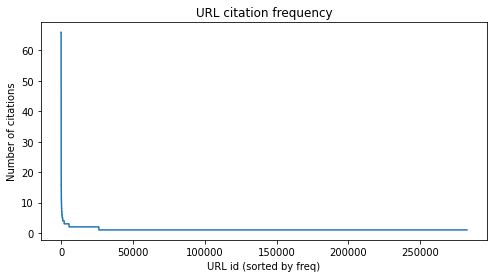

In [412]:
url_counts = scores["url"].value_counts()
plot_data = url_counts.reset_index()

ax = plot_data.plot(title="URL citation frequency", legend=False, figsize=[8,4])
ax.set_ylabel("Number of citations")
ax.set_xlabel("URL id (sorted by freq)")

plt.savefig("plots/url_freq_zipf.png")
plt.show()

In [387]:
url_counts_several = url_counts[url_counts > 1]
print(f"{len(url_counts_several)} URLs were used in more than one citation")

26229 URLs were used in more than one citation


In [388]:
url_counts_unique = url_counts[url_counts == 1]
print(f"{len(url_counts_unique)} URLs were used in only one citation")

256314 URLs were used in only one citation


26k URLs were used in more than one citation, that is 8% of our corpus, while 256k URLs were used in only one citation (80% of the URLs).

Below, we show the 10 most cited URLs of our corpus.

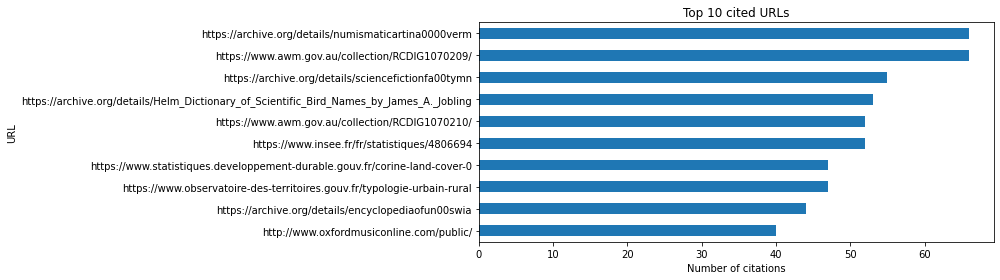

In [505]:
top_urls = url_counts_several.head(10).sort_values()

ax = top_urls.plot(figsize=[14,4], title="Top 10 cited URLs", legend=False, kind="barh")
ax.set_ylabel("URL")
ax.set_xlabel("Number of citations")

plt.tight_layout()
plt.savefig("plots/top_cited_urls.png")
plt.show()

In the following step, for each citation, Citoid's sucess is calculated as the sum of correct answers from the 7 evaluated metadata ('comp_author_first', 'comp_author_last', 'comp_title', 'comp_source_type', 'comp_pub_source', 'comp_pub_date_full','comp_pub_year'). For instance, if only the source type and the publishing year are correct, Citoid's sucess is 2. A response from Citoid is considered correct if the comparison with the manual data matches 75% or more.

In [523]:
def calculate_success(row):
    success_nr = 0
    fields = ['comp_author_first', 'comp_author_last', 'comp_title',
       'comp_source_type', 'comp_pub_source', 'comp_pub_date_full', 'comp_pub_year']
    
    correct_threshold = 0.75
    
    for field in fields:
        if row[field] >= correct_threshold:
            success_nr+=1
            
    return success_nr

scores['citoid_success'] = scores.progress_apply(
    lambda row: calculate_success(row),
    axis=1)

100%|██████████| 321179/321179 [00:16<00:00, 19774.39it/s]


In [524]:
scores

,url,source_type_citoid,wiki_lang,comp_author_first,comp_author_last,comp_title,comp_source_type,comp_pub_source,comp_pub_date_full,comp_pub_year,citoid_success
0,http://www.bbc.co.uk/programmes/b00rq1w3,webpage,en,1.0,1.00,0.24,1,1.00,1.0,1,6
1,http://www.gtaforums.com/index.php?showtopic=4...,webpage,es,1.0,1.00,0.35,0,0.69,1.0,1,4
2,https://archive.org/details/incharacter00john,book,en,0.0,0.19,1.00,1,0.57,0.0,1,3
3,http://news.ph.msn.com/business/article.aspx?c...,webpage,es,1.0,0.00,0.02,1,0.18,0.0,0,2
4,http://news.ph.msn.com/business/article.aspx?c...,webpage,pt,1.0,1.00,0.02,0,0.00,0.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...
321174,http://sportspressnw.com/2188385/2014/sounders...,webpage,en,1.0,0.00,0.66,1,0.38,0.0,0,2
321175,http://bibliotecadigital.unec.edu.br/ojs/index...,book,pt,0.0,0.09,0.29,0,0.00,0.0,0,0
321176,https://web.archive.org/web/20170313102855/htt...,webpage,pt,0.0,0.00,1.00,1,0.15,0.0,0,2
321177,http://www.jta.org/2009/09/03/news-opinion/uni...,blogPost,en,0.0,0.00,1.00,1,1.00,1.0,1,5


Now let's group the citations having the same URL, calculate the average success score for the repeated URLs and plot.

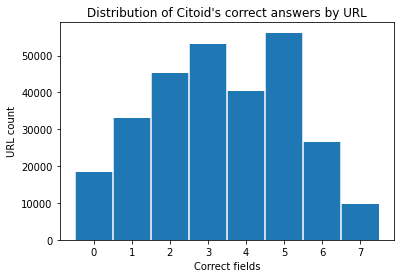

In [443]:
success_by_url = scores.groupby("url")["citoid_success"].mean().sort_values().reset_index()

bins = np.arange(9)
ax = success_by_url["citoid_success"].plot.hist(bins=bins)
for x in np.arange(8):
    ax.axvline(x, color="White")

xticks = (bins + 0.5)[:-1]

ax.set_xticks(xticks)
ax.set_xticklabels(bins[:-1])
ax.set_title("Distribution of Citoid's correct answers by URL")
ax.set_ylabel("URL count")
ax.set_xlabel("Correct fields")

plt.savefig("plots/citoid_success_by_url.png")
plt.show()

The majority of the citations received ~5 correct answers of 7, followed by ~3 correct answers. The citations having all 7 metadata fields correctly answered by Citoid are the smaller proportion.

### 6.2 By domain

In this section, we present the results of Citoid's evaluation by domain.

In [462]:
scores['domain'] = scores['url'].map(lambda x : urlparse(x).netloc)

In [406]:
domain_counts = scores["domain"].value_counts()
print(f"There are {len(domain_counts)} different domains in our corpus")

There are 43890 different domains in our corpus


We found 44k different domains in our corpus. Here is the top 10:

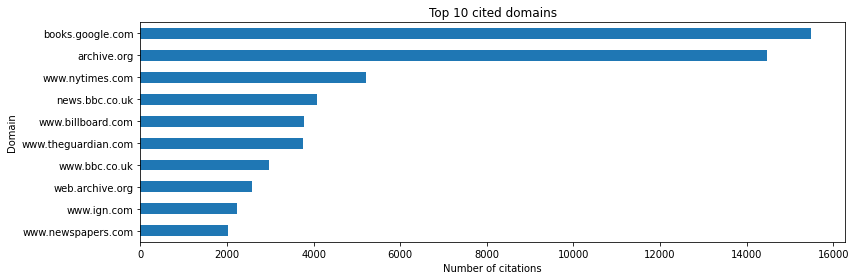

In [504]:
top_domains = domain_counts.head(10).sort_values()

ax = top_domains.plot(figsize=[12,4], title="Top 10 cited domains", legend=False, kind="barh")
ax.set_ylabel("Domain")
ax.set_xlabel("Number of citations")

plt.tight_layout()
plt.savefig("plots/top_cited_domains.png")
plt.show()

By far, the most cited domains are books.google.com and archive.org, having more than twice citations than the third most cited domain, www.nytimes.com. The rest the most cited domains belong mainly to news sites (news.bbc.co.uk, www.bbc.co.uk, www.theguardian.com, www.newspapers.com) and some specialized sites (www.billboard.com, www.ign.com, www.rollingstone.com). A special mention must be made to web.archive.org, a site for filing copies of websites, a good citation practice. 

Now let's visualize Citoid's performance for these domains:

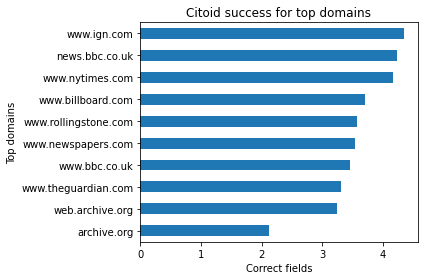

In [474]:
success_by_domain = scores.groupby("domain")["citoid_success"].mean().sort_values().reset_index()

plot_data = success_by_domain.set_index("domain").loc[top_domains.index]
plot_data = plot_data.sort_values(by="citoid_success")
ax = plot_data.plot.barh(legend=False)

ax.set_title("Citoid success for top domains")
ax.set_ylabel("Top domains")
ax.set_xlabel("Correct fields")

plt.tight_layout()
plt.savefig("plots/citoid_success_top_domains.png")
plt.show()

The overall success for the top domains is low, 7 of 10 sites present less than 4 correct answers. Furthermore, the performance for the most cited domain is very poor, only 2 correct fields of a total of 7. 

### 6.3 By language

In this section, we show the results for each Wikipedia. 

In [ ]:
## intro

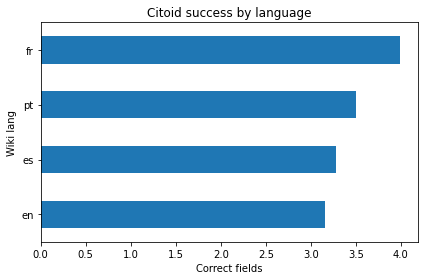

In [556]:
success_by_lang = scores.groupby("wiki_lang")["citoid_success"].mean().sort_values().reset_index()

plot_data = success_by_lang.set_index("wiki_lang")
plot_data = plot_data.sort_values(by="citoid_success")
ax = plot_data.plot.barh(legend=False)

ax.set_title("Citoid success by language")
ax.set_ylabel("Wiki lang")
ax.set_xlabel("Correct fields")

plt.tight_layout()
plt.savefig("plots/citoid_by_lang.png")
plt.show()

In [ ]:
## analysis

### 6.4 By sourcetype

This section shows Citoid's performance by source type.

In the following graphic we can observe the 10 most used source types. Webpage counts the overwhelming majority of the citations (almorst 70% of the corpus). It is followed by book, blogPost and newspaperArticle, which altogether represent 20% of the corpus.

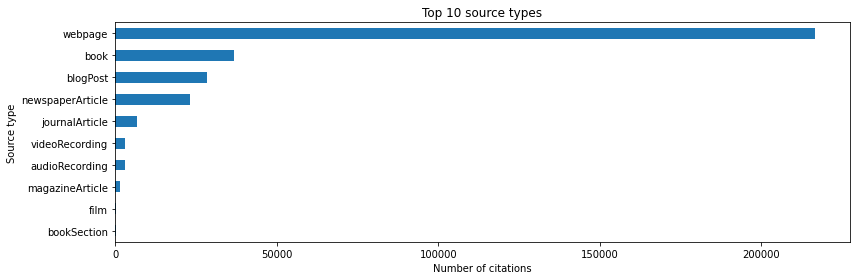

In [503]:
top_sources = scores["source_type_citoid"].value_counts().head(10).sort_values()

ax = top_sources.plot(figsize=[12,4], title="Top 10 source types", legend=False, kind="barh")
ax.set_ylabel("Source type")
ax.set_xlabel("Number of citations")

plt.tight_layout()
plt.savefig("plots/top_sourcetypes.png")
plt.show()


Now we will visualize Citoid's performance for these source types:

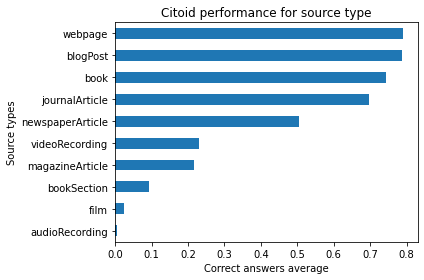

In [554]:
sourcetype_eval = scores.groupby("source_type_citoid")["comp_source_type"].mean().sort_values().reset_index()

plot_data = sourcetype_eval.set_index("source_type_citoid").loc[top_sources.index]
plot_data = plot_data.sort_values(by="comp_source_type")
ax = plot_data.plot.barh(legend=False)

ax.set_title("Citoid performance for source type")
ax.set_ylabel("Source types")
ax.set_xlabel("Correct answers average")

plt.tight_layout()
plt.savefig("plots/citoid_sourcetype_eval.png")
plt.show()

Citoid's answers for the most used source types present high values: 80% correct identification of webpages and blogPost, and 75% correct identification of book. The performance descends to 50% for nspaperArticle and to less than 30% for other source types but as we saw before, the frequency of source types in our corpus is low.

Two important observations must be noted here regarding the source type evaluation. On the one hand, we might be overestimating Citoid's success when identifying source types because modifying the citation template type when doing manual editions is not a simple change (it involves changing the whole template), hence Wikipedia editors usually leave them unmodified if the type is not correct. On the other hand, we might be underestimating Citoid's performance for source types because of our source type mapping (see section 4. Data normalization). Specific citation templates are not included in our mapping, leaving empty values in our manual data. In those cases, Citoid's response for the source type is interpreted as a missmatch with the manual data and penalized as incorrect.

Now let's observe Citoid's performance for all the fields by source type.

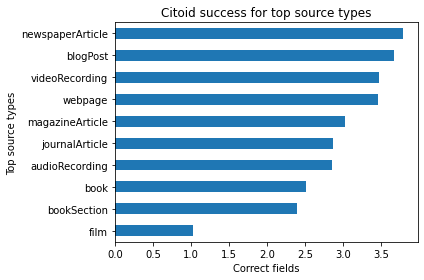

In [553]:
success_by_source = scores.groupby("source_type_citoid")["citoid_success"].mean().sort_values().reset_index()

plot_data = success_by_source.set_index("source_type_citoid").loc[top_sources.index]
plot_data = plot_data.sort_values(by="citoid_success")
ax = plot_data.plot.barh(legend=False)

ax.set_title("Citoid success for top source types")
ax.set_ylabel("Top source types")
ax.set_xlabel("Correct fields")

plt.tight_layout()
plt.savefig("plots/citoid_success_sourcetypes.png")
plt.show()

The number of correct answers displayed by source type is quite low: ~3 correct fields for newspaperArticle, blogPost, videoRecording and webpage. The performance is even lower for book, with only 2 correct answers of 7. In other words, the proportion of correct metadata returned by Citoid for the most used source types is low. 

### 6.1 By fieldname

#### Title

#### Author's first and last names

#### Publishing source

#### Publishing date